In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, backend
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import IPython.display as display
import pathlib
import glob

In [2]:
%run Models_and_functions.ipynb


After importing the libraries and other files, fetching the data and saving into the specific variables

In [3]:
# fetching data
train_images_path = 'H:\\Documents\\COMP3710\\keras_png_slices_data\\keras_png_slices_data\\keras_png_slices_train\\*.png'
train_images = sorted(glob.glob(train_images_path))

  
val_images_path =   'H:\\Documents\\COMP3710\\keras_png_slices_data\\keras_png_slices_data\\keras_png_slices_validate\\*.png'
val_images = sorted(glob.glob(val_images_path))

    
test_images_path =  'H:\\Documents\\COMP3710\\keras_png_slices_data\\keras_png_slices_data\\keras_png_slices_test\\*.png'
test_images = sorted(glob.glob(test_images_path))

    
train_labels_path = 'H:\\Documents\\COMP3710\\keras_png_slices_data\\keras_png_slices_data\\keras_png_slices_seg_train\\*.png'
train_labels = sorted(glob.glob(train_labels_path))

    
val_labels_path =   'H:\\Documents\\COMP3710\\keras_png_slices_data\\keras_png_slices_data\\keras_png_slices_seg_validate\\*.png'
val_labels = sorted(glob.glob(val_labels_path))

    
test_labels_path =  'H:\\Documents\\COMP3710\\keras_png_slices_data\\keras_png_slices_data\\keras_png_slices_seg_test\\*.png'
test_labels = sorted(glob.glob(test_labels_path))

    

For every image, there is a corresponding label

In [4]:
# pair image with label

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [5]:
len(train_images)

9664

In [6]:
# shuffle

train_ds = train_ds.shuffle(len(train_images))
val_ds = val_ds.shuffle(len(val_images))

For setting the image resoultion

In [7]:
BATCH_SIZE = 32
IMG_HEIGHT = 256
IMG_WIDTH = 256

Pre-processing data, getting the four classes

In [8]:
# to get palette for one hot map 
file_path1 = train_labels[0]
img = tf.io.read_file(file_path1)
decoded_image = decode_img(img)
palette = get_a_palette(decoded_image.numpy())
palette

[[1.0, 1.0, 1.0, 1.0],
 [0.6666666865348816, 0.6666666865348816, 0.6666666865348816, 1.0],
 [0.3333333432674408, 0.3333333432674408, 0.3333333432674408, 1.0],
 [0.0, 0.0, 0.0, 1.0]]

Mapping here decodes and sets the resoultion of the images and labels. It also applies the one-hot-map to the labels according the four classes found.

In [9]:
# Use Dataset.map to apply this transformation.
train_ds_map = train_ds.map(map_fn)
val_ds_map = val_ds.map(map_fn)
test_ds_map = test_ds.map(map_fn)

Initialize the UNET model

In [10]:
model = unet()

In [11]:
model.summary()

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 592         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization[0][0]        
_______________________________________________________________________________________________

Setting the parameters like dice coefficient for the loss and metric and then start the training

In [12]:
model.compile(optimizer="adam", loss=dice_coef_loss, metrics=[dice_coef])

In [13]:
history = model.fit(train_ds_map.batch(32), # using a batch size of 32
                    validation_data=val_ds_map.batch(32),
                    epochs=5)

Train for 302 steps, validate for 35 steps
Epoch 1/5
302/302 [==============================] - 300s 992ms/step - loss: 0.0315 - dice_coef: 0.9685 - val_loss: 0.0443 - val_dice_coef: 0.9557
Epoch 2/5
302/302 [==============================] - 310s 1s/step - loss: 0.0134 - dice_coef: 0.9866 - val_loss: 0.0174 - val_dice_coef: 0.9826
Epoch 3/5
302/302 [==============================] - 212s 700ms/step - loss: 0.0113 - dice_coef: 0.9887 - val_loss: 0.0102 - val_dice_coef: 0.9898
Epoch 4/5
302/302 [==============================] - 188s 623ms/step - loss: 0.0100 - dice_coef: 0.9900 - val_loss: 0.0108 - val_dice_coef: 0.9892
Epoch 5/5
302/302 [==============================] - 267s 884ms/step - loss: 0.0093 - dice_coef: 0.9907 - val_loss: 0.0100 - val_dice_coef: 0.9900


Using the test dataset, checking the model's predictions

In [15]:
image_test, label_test = next(iter(test_ds_map.batch(11)))
prediction = model.predict(image_test)

Comparing for
0 - Background

prediction 0:


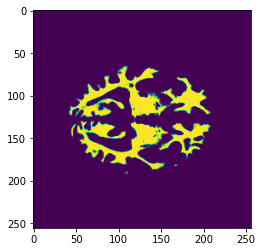

In [16]:
print("prediction 0:")
plt.imshow(prediction[0][:,:,0])

original 0:


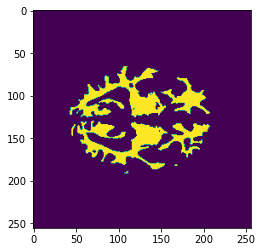

In [17]:
print("original 0:")
plt.imshow(label_test[0][:,:,0])

Comparing for
1 - CSF

prediction 1:


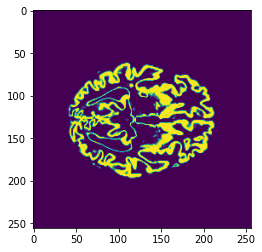

In [18]:
print("prediction 1:")
plt.imshow(prediction[0][:,:,1])

original 1:


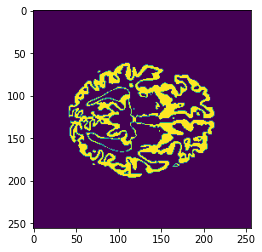

In [19]:
print("original 1:")
plt.imshow(label_test[0][:,:,1])

Comparing for
2 - Gray matter

prediction 2:


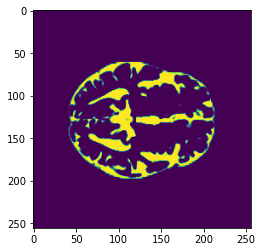

In [20]:
print("prediction 2:")
plt.imshow(prediction[0][:,:,2])

original 2:


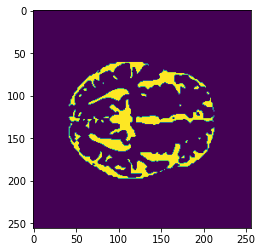

In [21]:
print("original 2:")
plt.imshow(label_test[0][:,:,2])

Comparing for
3 - White matter

prediction 3:


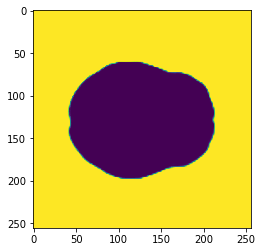

In [22]:
print("prediction 3:")
plt.imshow(prediction[0][:,:,3])

original 3:


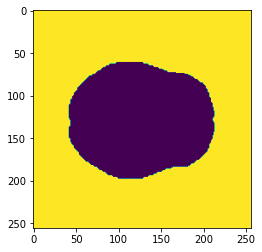

In [23]:
print("original 3:")
plt.imshow(label_test[0][:,:,3])

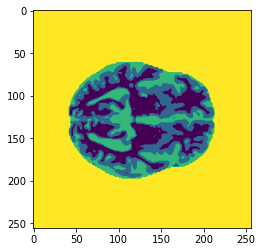

In [24]:
plt.imshow(tf.argmax(prediction[0],axis=-1))

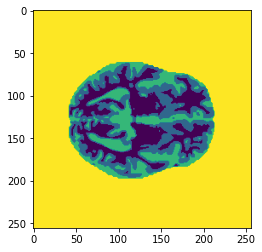

In [25]:
plt.imshow(tf.argmax(label_test[0],axis=-1))

Checking the dice coefficient when evaluating with the test dataset

In [26]:
results = model.evaluate(test_ds_map.batch(32), verbose=1)
print(results)

17/17 [==============================] - 15s 871ms/step - loss: 0.0096 - dice_coef: 0.9904
[0.009571366450365852, 0.99042857]
